# XGBoost

## Importar las librerías

In [3]:
import pandas as pd
import tensorflow as tf

## Importar el conjunto de datos

In [4]:
datos = pd.read_csv('Datos_Clasificados.csv')
X = datos.iloc[:, :-1].values
y = datos.iloc[:, -1].values

## División del conjunto de datos en un subconjunto para entrenamiento y otro para pruebas

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Limites para los hiperparametros

In [6]:
param_limits = {
    'n_estimators': (50, 200, 'int'),
    'max_depth': (3, 10, 'int'),
    'learning_rate': (0.01, 0.3, 'float'),
    'subsample': (0.5, 1.0, 'float')
}

In [7]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, test_size=0.2)

def create_model(individual):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=individual['max_depth'] * 10, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(1 - individual['subsample']),
        *[tf.keras.layers.Dense(units=individual['max_depth'] * 10, activation='relu') for _ in range(individual['n_estimators'])],
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=individual['learning_rate']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Fitness function para obtener un score númerico

In [8]:
def fitness_function(individual):
    model = create_model(individual)
    
    model.fit(X_train_part, y_train_part, epochs=5, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_val_part, y_val_part, verbose=0)
    return accuracy

## Instancia del optimizador genético

In [9]:
from optimizer import GeneticAlgorithmOptimizer

optimizer = GeneticAlgorithmOptimizer(
    param_limits=param_limits,
    fitness_function=fitness_function,
    population_size=20,
    generations=20,
    crossover_rate=0.8,
    mutation_rate=0.2,
    tournament_size=3,
    verbose=True
)

In [10]:
import warnings
warnings.filterwarnings('ignore')

best_params, best_score = optimizer.run()

Generation 1/20


KeyboardInterrupt: 

## Obtener la Matriz de Confusión con los mejores hiperparámetros

In [ ]:
classifier = create_model(best_params)
classifier.fit(X_train, y_train, epochs=5, batch_size=32)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14235755729618949, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=108, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 79   7]
 [  7 107]]


0.93

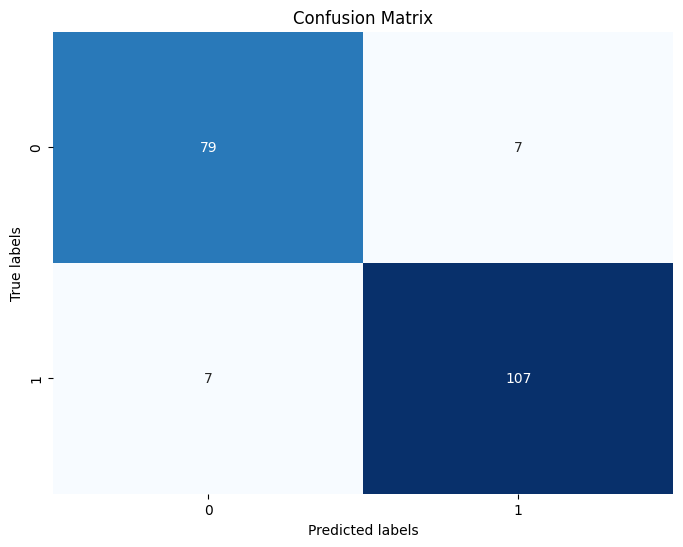

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()